# CIS 545 Homework 5: Deep Learning with Pytorch

### Due Tuesday, April 18, 2023 10:00 PM EST

Welcome to CIS 545 Homework 5! 

In this homework, we will learn more about the 'new electricity' - Deep Learning (I didn't coin this, Andrew Ng did) ! There are many cool frameworks for building deep learning models - PyTorch, Tensorflow, Theano, MxNet. Since you will be working with Big Data in this course, you need a framework that scales well. Almost all of these have a multi-gpu support built in. In this assignment, we will be building neural networks in PyTorch to solve an interesting problem.

Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing. So let's take a 'deep' dive into it.


![alt text](http://4.bp.blogspot.com/-sLgBLS3bJO8/U__Kx6PnkRI/AAAAAAAAAWM/Gz3cL5jiwTo/s320/godeeper.jpg)





## Why deep learning? 


*   It's coooool
*   Everyone is talking about is these days, people like Siraj Raval can teach it in 5 mins (Check out his [YouTube channel](https://www.youtube.com/channel/UCWN3xxRkmTPmbKwht9FuE5A) for some comedy)
*    Deep learning unlocks the treasure trove of unstructured big data for those with the imagination to use it
*   Deep learning models have great representational power and are 'universal approximators'


### Deep Learning Applications:


Deep learning has significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, which is why experts think that this technology is the future of almost everything. There are truly deep learning technologies such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning - 

Here's a neural network detecting anomalies in Chest Xrays :




![alt text](https://imgur.com/HKPzrzP.jpg)

Most humans can't tell that this is a case of Pleural Effusion {sounds like medical jargon to engineers like us} but this Neural Network model can detect it very well!

Mask RCNNs in action for detecting objects on the road aiding a self driving vehicle's driving: 
<div>
<img src="https://miro.medium.com/max/3864/1*O4wsvh0CHWjP6IrK9HI_Zg.png", width="800"/>
</div>

Pretty cool, right? We will be applying CNNs to solve a cool image classification problem.


# Libraries and Setup Jargon (Total: 1 point)
Run the following cells to set up the notebook.


Please make sure you enter your **8 digit Penn ID** in the  student ID field below.

In [1]:
%%capture
!pip install -i https://test.pypi.org/simple/ penn-grader==0.5.0
from penngrader.grader import *

#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND

STUDENT_ID = 30808116       # YOUR PENN-ID GOES HERE AS AN INTEGER

In [2]:
%%writefile config.yaml
grader_api_url: 'https://wyv616tp17.execute-api.us-east-1.amazonaws.com/default/Grader'
grader_api_key: 'Kd32fl3g3p917iM0zwjiO23Bitj4PO9ga4LektOa'

Writing config.yaml


In [3]:
grader = PennGrader('config.yaml', 'CIS5450_23Sp_HW5', STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 30808116

Make sure this correct or we will not be able to store your grade


## Import the required Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive

## Set up GPU capabilities (1 point)

The cell below sets up a CUDA device to use with torch, if available to you.

**Remeber to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU


Note that you can create a PyTorch tensor `T` that resides on the GPU using the command `T = torch.Tensor(..., device=cuda)`. 
You can also copy existing tensors to the GPU with the command `T = T.to(device)` (make sure to overwrite `T` with the result of this function call). If you do not have a GPU, these commands will still work.

**NOTE**: The grader cell below is to check that you are using the GPU, since it is beneficial in later sections that require parallel computation on arrays (i.e., Section 2).

In [5]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.0.0+cu118
cuda:0


In [6]:
device

device(type='cuda', index=0)

In [7]:
# Grader Cell (1 points)
grader.grade(test_case_id = 'device', answer = str(device))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **Part 1:** Data Preprocessing and Preparation for Modeling in `PyTorch` (Total: 20 points)

In this homework we will tackle the problem of classifying images.

Specifically, we would be looking at the Modified National Institute of Standards and Technology database ([MNIST](https://en.wikipedia.org/wiki/MNIST_database)) dataset.

<div>
<img src="https://s2.loli.net/2023/03/26/GwFJhNeskzE5Ptx.webp", width="800"/>
</div>

Diagram Reference: [Link](https://en.wikipedia.org/wiki/MNIST_database)

[MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html) dataset consists of 60,000 28x28 grayscale images in 10 classes. 

There are 60,000 training images and 10,000 test images.

While it is good to have as much training data as possible, in order to avoid having long training time and potentially running out of GPU, we will downsample and train the model with 30,000 training images and 5,000 testing images.


We would be using this dataset to train 3 different models:

1.   Logistic Regression
2.   Feedforward (Fully-Connected) Neural Network
3.   Convolutional Neural Network

And analyze the difference between these models by looking at the test accuracy and loss.



## 1.1 Pytorch Dataset and DataLoader (Total: 10 points)

To keep data loading consistent across different models, PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.

`Dataset` stores the samples and their corresponding labels. And `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples. More information and examples of the objects in action can be found **[here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)**

While Pytorch provides `Dataset` and `Dataloader` for some popular datasets (i.e., one can instantiate the objects and the data is ready to be analyzed in PyTorch Machine Learning pipeline), sometimes we need to define our own custom `Dataset` to process our dataset. The list of available built-in datasets PyTorch gave us can be found **[here](https://pytorch.org/vision/stable/datasets.html)**

<div>
<img src="https://s2.loli.net/2023/03/30/yxbP8gXCroO1Y7c.png", width="800"/>
</div>

Diagram Reference: [Link](https://www.kaggle.com/code/uvxy1234/cifar-10-implementation-with-pytorch)

Dataset class is defined with 3 components:

1.   __init__ : setting up the parameters being used in the class (e.g., `transforms` which corresponds to the transformation being applied)
2.   __len__ : so that len(dataset) returns the size of the dataset.
3.   __getitem__ to support the indexing such that `dataset[i]` can be used to get `i`ith sample (in our case Image, label pair).

To create a custom Dataset object, you would need overide above functions.

Documentation for creating custom dataset can be found [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Luckily, as MNIST is a classic image dataset, we do not need to worry about creating custom `Dataset` and `DataLoader` objects since they are all built into the PyTorch when you import that above.

Complete the missing code in the two sections below.

*   **1.1.1 Instantiate Train and Test Dataset.** $\to$ Load and transform data such that it is ready to be passed into the model
*   **1.1.2 Instantiate Train and Test Dataloader.** $\to$ Put the data into the iterable such that the model is able to process data in batch from using `DataLoader`


### 1.1.1 Instantiate Dataset (for train/test dataset) (6 points)

One optional function in Dataset class is `transform`, where we can apply a transformation to the dataset before we load them as a dataloader. 

For example if we define a `Resize` function in transform, all of our dataset(images) would be resized to specified size passed in as an argument.

---
**TODO**: complete the code to apply following transformations (in order!!) by using `transforms.Compose` and save it to the variable `transform`:

1.   Resize the image to 28 by 28 $\to$ just to make sure they are really have size $28$x$28$
2.   Convert the images to Tensor
3.   Rotate the image using `RandomRotation` with the range of rotation between $(-45°,45°)$
4.   Add random perspective shift using `RandomPerspective` with the distortion of `0.3` to `50%` of the data. 
5.   Normalize the Tensor using mean value of `0.1307` and standard deviation value of `0.3081`
---
**NOTE**: We highly recommend looking at [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html) and some [illustrations](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) before proceeding with the code

Please review the the recitation notebook for detailed instructions on how to perform these operations. 

**FYI**: The values `0.1307` and `0.3081` are mean and standard deviation, respectively, of the MNIST dataset [Ref](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/4)

**NOTE**: Please store the distortion of image in the variable `distortion_scale` since it will be used as an input into the autograder.

In [8]:
scale = 28
distortion_scale = 0.3
# TODO
transform = transforms.Compose([
            transforms.Resize((scale,scale)),
            transforms.ToTensor(),
            transforms.RandomRotation((-45,45)),
            transforms.RandomPerspective(distortion_scale = 0.3, p = 0.5),
            transforms.Normalize((0.1307,), (0.3081,))
])


# TODO END

Now that we have defined the tranforms we are going to apply to the dataset, let's instantiate `Dataset` objects for both the training and testing sets using predefined PyTorch Dataset. Refer to the documentation [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html).

In addition, since the whole dataset is pretty large for running the model, we will also be downsampling by reducing the size of the dataset by half.

---
**TODO**:
* Initiate the `Dataset` object for the training set as `train_dataset`
* Downsample training by getting the train data at even-numbered indices, specified as `train_subset`
* Initiate the `Dataset` object for the testing set as `test_dataset`
* Downsample testing by getting the test data at even-numbered indices, specified as `test_subset`
---

**Hint**: Check out [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) for downsampling the dataset.

**Note**: When initiating the `Dataset` object for both training and testing sets, in addition to other arguments please set these arguments as follows:
* `root = './data'`
* `download = True`

In [9]:
import torch.utils.data as data
# TODO
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_subset = data.Subset(train_dataset, range(0, len(train_dataset), 2))

# Define the testing set with downsampling
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_subset = data.Subset(test_dataset, range(0, len(test_dataset), 2))
# TODO END

100%|██████████| 9912422/9912422 [00:00<00:00, 250214920.83it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 90063712.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65074206.05it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19479068.27it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**NOTE**: Please do not forget to store the distortion of image in the variable `distortion_scale`.

In [10]:
#Grader Cell (6 points)
transforms_train = []
for i in range(len(train_dataset.transform.transforms)):
  transforms_train.append(str(train_dataset.transform.transforms[i]))
transforms_test = []
for i in range(len(test_dataset.transform.transforms)):
  transforms_test.append(str(test_dataset.transform.transforms[i]))
grader.grade(test_case_id = 'instantiate_dataset', answer = (transforms_train, transforms_test, len(train_subset), len(test_subset), distortion_scale))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Hint:** For the above grader cell, part of the criterias we are checking is if the **transform** object is set up correctly.

### 1.1.2 Dataloader - Train / Test (4 points)

Now that we have `trainDataset` and `testDataset`, let's create dataloaders using these two datasets.

You can load the dataset into dataloaders using the `DataLoaders` object. Please refer to the documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). 
 
---
**TODO**:
* Initialize the `DataLoader` object for `train_subset` as `train_loader`
* Initialize the `DataLoader` object for `test_subset` as `test_loader`
---

**NOTE**: set the `batch_size` equal to the previously-defined variable `batch`, set `shuffle` to `True`, and `num_workers` as 0.


In [11]:
batch = 64
# TODO
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)

# TODO END

In [12]:
#Grader Cell (4 points)
trainLoaderCheck = [getattr(train_loader, "batch_size"),
                    str(type(train_loader)),
                    len(getattr(train_loader, "dataset")),
                    str(getattr(train_loader, "sampler")),
                    getattr(train_loader, "num_workers")]
testLoaderCheck = [getattr(test_loader, "batch_size"),
                    str(type(test_loader)),
                    len(getattr(test_loader, "dataset")),
                    str(getattr(test_loader, "sampler")),
                    getattr(test_loader, "num_workers")]
grader.grade(test_case_id = 'check_dataloader', answer = (trainLoaderCheck, testLoaderCheck))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.2 Summarizing our Dataset (Total: 10 points)

Getting a good sense of the dataset we are going to work on is always the first step you should take when implementing ML applications.

In this section, we will be looking at the distribution of the dataset (e.g., how many instances belong to class with label `0`) and visualize what we are dealing with (i.e., plot out the sample images)

### 1.2.1 Looking at the distribution of labels (6 points)

We can look at the distribution of labels by retrieving the labels of all possible instances of the subset of data pulled from `train_dataset` and `test_dataset` (i.e., `train_subset` and `test_subset`) for the training and testing data, respectively. We defined this in section `1.1.1`.

---
**TODO**
* Train
  * Get the number of unique labels in training dataset and save this quantity as the variable `train_num_labels`. 
  * Create a `DataLoader` called `train_loader_bar_plot` which takes as arguments the `train_subset`, with the following parameters:
    * `batch_size` = length of the `train_subset`
    * `shuffle = True`
    * `num_workers = 0`
  * Create a dictionary `train_subset_dict` that contains the labels as keys and the number of images inside the label as values. 
* Test
  * Get the number of unique labels in testing dataset and save this quantity as the variable `test_num_labels`. 
  * Create a `DataLoader` called `test_loader_bar_plot` which takes as arguments the `test_subset`,  with the following parameters:
    * `batch_size` = length of the `test_subset`
    * `shuffle = True`
    * `num_workers = 0`
  * Create a dictionary `test_subset_dict` that contains the labels as keys and the number of images inside the label as values.
---
Please refer to **[this](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)** for instantiating the `DataLoader`, which is similar to what we did in section `1.1.2`

In [61]:
# TODO - TRAIN Data
from collections import Counter
# Use the original train dataset (with 60,000 images) object to obtain the number of label classes train data
train_num_labels = len(Counter(train_dataset.targets.numpy()))
train_loader_bar_plot = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=0)

# Creating dictionary for train dataset 

train_subset_dict = {}
for image, label in train_loader_bar_plot: 
  train_subset_dict = dict(Counter(list(label.numpy())))
# END TODO


print(train_subset_dict)

{3: 2985, 6: 2994, 8: 2883, 4: 2958, 9: 3005, 0: 2819, 5: 2841, 1: 3370, 7: 3149, 2: 2996}


In [62]:
# TODO - TEST Data

# Use the original test dataset (with 10,000 images) object to obtain the number of label classes in test data
test_num_labels = len(Counter(test_dataset.targets.numpy()))
test_loader_bar_plot = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=0)

# Creating dictionary for test dataset 

test_subset_dict = {}
for image, label in test_loader_bar_plot: 
  test_subset_dict = dict(Counter(list(label.numpy())))
# END TODO
print(test_subset_dict)

{0: 451, 1: 591, 2: 501, 5: 458, 8: 466, 6: 499, 4: 480, 7: 519, 3: 511, 9: 524}


In [63]:
#Grader Cell (6 points)
grader.grade(test_case_id = 'dataset_dict', answer = (train_num_labels, train_subset_dict, test_num_labels, test_subset_dict))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.2 Visualize through bar charts (2 points - Manual Grading)

Now we are going to visualize the distribution of labels using bar charts for both training and testing set which we store the distributions in their respective dictionary objects in section 1.2.1.

---
**TODO: You can use either `matplotlib` or `seaborn` for this section**
* Create a barplot for the distributions of training labels using `train_subset_dict` with x-axis label as `Labels` and y-axis label as `Frequency`, and title as `Training set labels and corresponding frequencies`
* Create a barplot for the distributions of testing labels using `test_subset_dict` with x-axis label as `Labels` and y-axis label as `Frequency`, and title as `Testing set labels and corresponding frequencies`
* Add corresponding `labels` to the barplots (i.e., if label 1 has the count of 1200, "1200" should appear above the bar corresponding to label 1)
-  To avoid "File Too Large" for submission, please set figure size to (8,6).
---
**NOTE**:

* y-axis $\to$ Number of data points
* x-axis $\to$ The integer value of the labels in the MNIST dataset 

Text(0.5, 1.0, 'Number of Data Points per Unique Label')

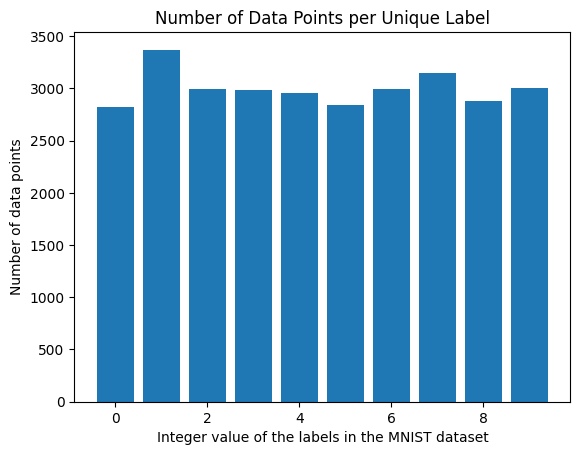

In [16]:
# TODO: Create a barplot showing the distribution of the dataset
# TRAIN Data

plt.bar(train_subset_dict.keys(), train_subset_dict.values())
plt.xlabel('Integer value of the labels in the MNIST dataset')
plt.ylabel('Number of data points')
plt.title('Number of Data Points per Unique Label')

Text(0.5, 1.0, 'Number of Data Points per Unique Label')

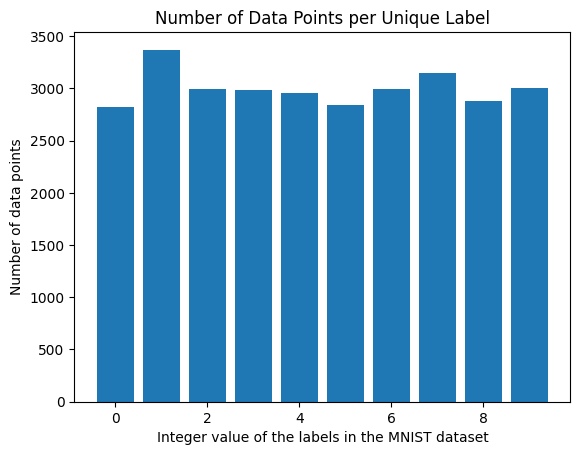

In [17]:
# TODO: Create a barplot showing the distribution of the dataset
# TEST Data
plt.bar(test_subset_dict.keys(), test_subset_dict.values())
plt.xlabel('Integer value of the labels in the MNIST dataset')
plt.ylabel('Number of data points')
plt.title('Number of Data Points per Unique Label')

### 1.2.3 Visualize the Training Dataset! (2 points - Manual Grading)

Since everything tends to make more sense when one could literally see it, we now ask you to visualize the images in the `train_dataset` given a fixed set of indices.

---

**TODO**
* loop through the `train_dataset` using `sample_idxs` (the list of indices provided) using a for-loop
* For each iteration of this for-loop:
  * Plot the current image in grayscale from `train_dataset` indexed by current element in `sample_idxs` using matplotlib in a $2x3$ subplot tile
  * Assign the title of each image to be their respective labels using `plt.title`
  * Hide grid lines and axes labels
  * To avoid "File Too Large" for submission, please set overall figure size to (8,4), not individual image.
---
**HINT**: use `enumerate` in for-loop initialization and apply the current loop number to the subplot

**NOTE**: `train_dataset` can be indexed by `train_dataset[index]` and you should play around with the output format to get the image and labels



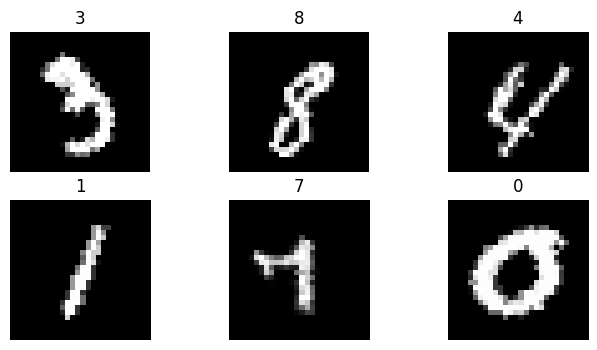

In [18]:
from sklearn.utils.validation import indexable
torch.manual_seed(42)
sample_idxs = [10, 300, 700, 2708, 5035, 8000] # DO NOT MODIFY

# # TODO
# loop through the length of tickers and keep track of index

fig, ax = plt.subplots(2, 3, figsize=(8, 4))

for i, idx in enumerate(sample_idxs):
    
    image, label = train_dataset[idx]
    
    ax[i//3, i%3].imshow(image.squeeze(), cmap='gray')
    ax[i//3, i%3].set_title(label)
    
    plt.axis('off')
    
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].grid(False)
# END TODO

# **Part 2:** Classification Models (Total: 79)

We now have the data needed to train a multi-class object classifier. We will start simple with a logistic regression classifier as a baseline for our performance, before we move onto more complex neural networks.

In this case, we are looking at the remaining part in the pipeline which were grayed out before as follows:

<div>
<img src="https://s2.loli.net/2023/03/30/ZCBFQvkXuoJpI8K.png", width = "800"/>
</div>

Diagram Reference: [Link](https://www.kaggle.com/code/uvxy1234/cifar-10-implementation-with-pytorch)

## 2.1 Logical Logistic Regression - Baseline (Total: 15 points)

Let's first try solving this problem with a Logistic Regression classifier.

We will define a logistic regression model in Pytorch and train it on our training set and evaluate the performance on the test set.

Logistic regression can be modelled as a function that can take in any number of inputs and constrain the output to be between 0 and 1. This means we can think of Logistic Regression as a one-layer neural network without hidden layers with Sigmoid as an activation function.

<div>
<img src='https://i.stack.imgur.com/fKvva.png',width='600'/>
</div>

Diagram Reference: [Link](https://stats.stackexchange.com/questions/366707/a-logistic-regression-with-neural-network-mindset-vs-a-shallow-neural-network)

### 2.1.1 Logistic Regression Model Architecture (5 points)

We will define our first model in Pytorch. Read up about how to define and use layers in a Pytorch neural network [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). 

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Please implement the constructor for the `LogReg` class (the `__init__` function below) with the definition of the logistic regression model.

When implementing this section, please think about what activation function would be most appropriate for logistic regression.

In [19]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers
        self.linear = nn.Linear(in_features = scale*scale, out_features = 10)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        # END TODO

    def forward(self, x):
        # TODO: implement the operations on input data
        # Hint: think of the neural network architecture for logistic regression
        outputs = self.flatten(x)
        outputs = self.sigmoid(self.linear(outputs))    
        # END TODO
        return outputs

Let's print the model summary

In [20]:
LogReg()  

LogReg(
  (linear): Linear(in_features=784, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [21]:
#Grader Cell (5 points)
grader.grade(test_case_id = 'logistic_regression_model', answer = str(LogReg()))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Notes:** Getting full credit for the above test case doesn't necessarily ensure that your model will perform well on the test dataset as it only evaluates the structure of your neural network.

If you don't achieve complete credit for accuracy and loss on the test dataset, you may need to modify your architecture.

### 2.1.2 Training Logistic Regression Model (6 points)
---
**TODOs:**
1.   Instantiate the Logistic regression to the variable `logreg`. Make sure to send this to the GPU device -- please consult the [Module 20 slides](https://docs.google.com/presentation/d/1pw9cFO30U_kI47JUZIW9COLAkM8BE8wr/edit?usp=sharing&ouid=115607071793138372214&rtpof=true&sd=true) for a primer on how to do this.

2.   Set the loss criterion as `CrossEntropyLoss` (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions)). Note that softmax is already built into CrossEntropyLoss so if you use CrossEntropyLoss as the loss criterion, you don't need to add an additional softmax layer. 

3.   Fill in the missing parts in the training loop (see `#TODO` comments below)
4.   Save the Training Accuracy for every epoch into the variable `acc_LIST_log`.
5.   Save the Average Loss for every epoch into the variable `loss_LIST_log`.
---
We will use `train_loader` built in 1.1.2 to train logistic regression model.

The optimizer is set as Adam -- **please do not modify the optimizer**.

Hint: Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`.

**Note: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly**

Note: `acc_LIST_log` and `loss_LIST_log` should contain data of type float not tensor.

In [22]:
%%time
# Sending the data to device (CPU or GPU)
# TODO: (1 of 2) 
# Step 1: instantiate the logistic regression to variable logreg
logreg = LogReg().to(device)

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Logistic Regression
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      
      ## TODO (2 of 2)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      outputs = logreg(inputs)
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      loss = criterion(outputs, labels)
      loss.backward() 
      optimizer.step()
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      running_loss += loss.item()
      # Step 5: Do a back propagation
      total += labels.size(0)
      # Step 6: Update the weight using the gradients from back propagation by learning step

      # Step 7: Get loss and add to accumulated loss for each epoch

      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      
      correct += (predicted == labels).sum().item()
  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_log
  accuracy = 100 * correct / total
  acc_LIST_log.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  loss_LIST_log.append (running_loss / len(train_loader)) 
  # END TODO
  
  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 2.09885828581446, Accuracy = 45.74666666666667
The loss for Epoch 1 is: 1.9462355848060233, Accuracy = 59.263333333333335
The loss for Epoch 2 is: 1.8939586018702623, Accuracy = 61.27
The loss for Epoch 3 is: 1.866617905814002, Accuracy = 62.5
The loss for Epoch 4 is: 1.8502502809963755, Accuracy = 62.54666666666667
The loss for Epoch 5 is: 1.8375960664708477, Accuracy = 63.39666666666667
The loss for Epoch 6 is: 1.8259001444143528, Accuracy = 63.70333333333333
The loss for Epoch 7 is: 1.8199616050415202, Accuracy = 63.6
The loss for Epoch 8 is: 1.8130142282067077, Accuracy = 64.05333333333333
The loss for Epoch 9 is: 1.810695304036903, Accuracy = 63.943333333333335
CPU times: user 6min 4s, sys: 2.14 s, total: 6min 6s
Wall time: 6min 13s


In [23]:
# (if applicable)
# In order to pass the AutoGrader, every element in "acc_LIST_log" should be a float. 
# If the elements are of type "Tensor", convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out "acc_LIST_log" and see if there is a Tensor() wrapped around each element.


In [24]:
# Grader Cell (6 points)
grader.grade(test_case_id = 'log_train_loss', answer = (acc_LIST_log, loss_LIST_log))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression (2 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

<Figure size 500x300 with 0 Axes>

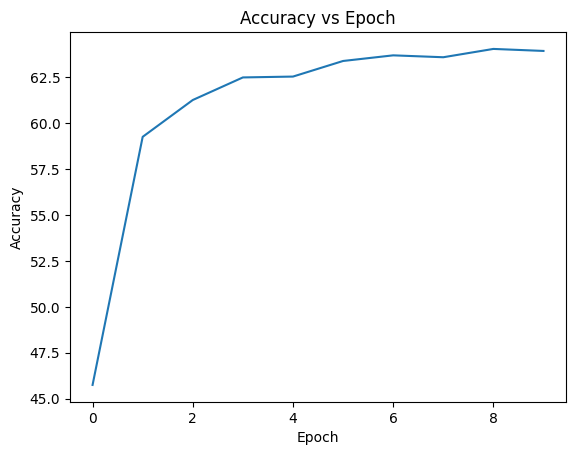

<Figure size 500x300 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.plot(np.arange(epoch+1), acc_LIST_log)
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.figure(figsize = (5,3))

# END TODO 


### 2.1.4 Logistic Regression Model Accuracy (2 points)

Calculate the Test Accuracy for the Logistic Regression Model we trained above.

This should be similar to how we calculated training accuracy above.

In [26]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        # TODO
        # Get the output
        outputs = logreg(images)
        
        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Calculate test accuracy for logistic regression (should multiple by 100)
test_acc_log = torch.tensor(100*correct/total)

# TODO END
print('Test Accuracy: ' + str(test_acc_log.item()))

Test Accuracy: 64.55999755859375


In [27]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'logistic_regression_test_acc', answer = test_acc_log.item())

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2 Feedforward Neural Networks (Total: 25 points)

<div>
<img src='https://s2.loli.net/2022/11/21/dvqstVUzcQPChD1.png', width='400'/>
</div>

Diagram reference: [Link](https://en.wikipedia.org/wiki/Feedforward_neural_network)

Since logistic regression isn't that great at the classification problem above, we need more representation power in our model. We will now define a feedforward neural network.

Complete the *FNN* class below to define a feedforward neural network with **only 1 hidden layers with ```out_features``` of 256**. Note that the last layer must have the same number of classes as the output size! 

When implementing this model, please think about what activation function would be most appropriate for each layer in this classifier. 

### 2.2.1 Feedforward Neural Network Model Architecture (10 points)

In [28]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers
        self.linear = nn.Linear(in_features = scale*scale, out_features = 256)
        self.linearHiddenLayer = nn.Linear(in_features = 256, out_features = 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # END TODO

    def forward(self, x):
        # TODO: implement the operations on input data
        # Hint: think of the neural network architecture for FNN
        x = self.flatten(x)
        x = self.linear(x)
        x = self.relu(x)
        outputs = self.linearHiddenLayer(x)

        # END TODO
        return outputs

Let's print the model summary

In [29]:
FNN()

FNN(
  (linear): Linear(in_features=784, out_features=256, bias=True)
  (linearHiddenLayer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [30]:
#Grader Cell (10 points)
grader.grade(test_case_id = 'feedforward_nn_model', answer = str(FNN()))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Notes:** Getting full credit for the above test case doesn't necessarily ensure that your model will perform well on the test dataset as it only evaluates the structure of your neural network.

If you don't achieve complete credit for accuracy and loss on the test dataset, you may need to modify your architecture such as increasing the number of hidden layers or the number of neurons in each layer.

### 2.2.2 Training FNN Model (11 points)
---
TODOs
1.   Instantiate the FNN to the variable `fnn` (make sure to send this to the device env)
2.   Set the loss criterion to be `CrossEntropyLoss` (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
3.   Fill in the missing parts in the training loop below.
4.   Save the Training Accuracy for every epoch into `acc_LIST_FNN`
5.   Save the Average Loss for every epoch into `loss_LIST_FNN`
---
The optimizer is set as Adam -- **please do not modify the optimizer**.

Hint: Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`.

**Note: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly**

The following code bloack should take around 4-5 minutes to complete.

Note: `acc_LIST_FNN` and `loss_LIST_FNN` should contain data of type float not tensor.

In [31]:
%%time
# Sending the data to device (CPU or GPU)
# TODO (1 of 2)
# Step 1: instantiate the FNN model to variable fnn
fnn = FNN().to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# END TODO 
optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)
      
      ## TODO (2 of 2)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      outputs = fnn(inputs)
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      loss = criterion(outputs, labels)
      loss.backward() 
      optimizer.step()
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      running_loss += loss.item()
      # Step 5: Do a back propagation
      
      # Step 6: Update the weight using the gradients from back propagation by learning step

      # Step 7: Get loss and add to accumulated loss for each epoch

      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_FNN
  accuracy = 100 * correct / total 
  acc_LIST_FNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN

  loss_LIST_FNN.append(running_loss / len(train_loader))
  
  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 1.3275399360575402, Accuracy = 59.406666666666666
The loss for Epoch 1 is: 0.9665064280475381, Accuracy = 70.14
The loss for Epoch 2 is: 0.8440812061082071, Accuracy = 74.10333333333334
The loss for Epoch 3 is: 0.7538247549457591, Accuracy = 76.87666666666667
The loss for Epoch 4 is: 0.677612337476409, Accuracy = 79.47666666666667
The loss for Epoch 5 is: 0.6111487756405812, Accuracy = 81.65666666666667
The loss for Epoch 6 is: 0.5739663878737736, Accuracy = 82.88333333333334
The loss for Epoch 7 is: 0.5313202647893414, Accuracy = 84.16
The loss for Epoch 8 is: 0.5020944841507909, Accuracy = 84.95333333333333
The loss for Epoch 9 is: 0.4713931022358856, Accuracy = 85.82666666666667
CPU times: user 6min 4s, sys: 1.34 s, total: 6min 6s
Wall time: 6min 6s


In [32]:
# (if applicable)
# In order to pass the AutoGrader, every element in "acc_LIST_FNN" should be a float. 
# If the elements are of type "Tensor", convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out "acc_LIST_FNN" and see if there is a Tensor() wrapped around each element.
print(acc_LIST_FNN)

[59.406666666666666, 70.14, 74.10333333333334, 76.87666666666667, 79.47666666666667, 81.65666666666667, 82.88333333333334, 84.16, 84.95333333333333, 85.82666666666667]


In [33]:
#Grader Cell (11 points)
grader.grade(test_case_id = 'fnn_train_loss', answer = (acc_LIST_FNN, loss_LIST_FNN))

Correct! You earned 11/11 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.3 Plotting Training Accuracy vs Epochs FNN (2 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

<Figure size 500x300 with 0 Axes>

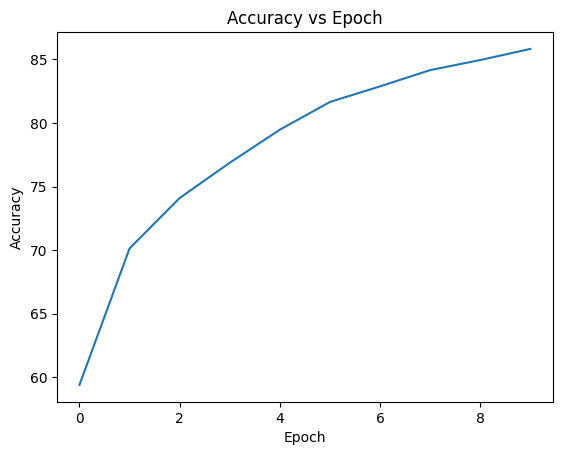

<Figure size 500x300 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.plot(np.arange(epoch+1), acc_LIST_FNN)
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.figure(figsize = (5,3))
# END TODO


### 2.2.4 FNN Model Accuracy(2 points)

Calculate the Test Accuracy for the FNN Model we trained above (the technique for doing this is the same as computing the test accuracy for the logistic regression classifier above). 

In [35]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # TODO
        # Get the output
        outputs = fnn(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data,1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN = torch.tensor(100*correct/total)
# TODO END
print('Test Accuracy: ' + str(test_acc_FNN.item()))

Test Accuracy: 87.19999694824219


In [36]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'feedforward_nn_acc', answer = (test_acc_FNN.item(), loss_LIST_FNN))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


##2.3 "Convoluted" Convolutional Neural Networks (Total: 29 points)
So, what are CNNs?

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other.

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend this [page](https://cs231n.github.io/convolutional-networks/)

<div>
<img src='https://s2.loli.net/2022/11/21/L6pUz2chXWRGn31.png', width='800'>
</div>

Diagram Reference: [Link](https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/)

We will define the architecture for the CNN we will be using. The components of a CNNs are as follows: 

*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Pytorch that contains one or more blocks, where **each block** consists of a **convolutional layer** followed by an **activation function** and a **max pool**. (For this assignment, we discourage adding three or more layers.)

Then, **flatten** the output from the convolutional layers, and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

### 2.3.0 Calculating Output Dimensions of Convolution and Pooling Layers (3 Points)

Before we start building the architecture, it's important to understand the dimensions of the feature maps produced in each of the convolution and pooling layers. We want to keep track of this information as once we get to the fully-connected layers, we need to specify the number of input parameters. 

Let's first build a function that will help us calculate the dimensions based on the input parameters.


Since we are working with squared image, we will build just one function that can be used to calculate both the H (height) and W (width) of the feature map.

Below is the function used to calculate the output dimension of the feature map: 

<div>
<img src='https://s2.loli.net/2023/03/30/lKpjPLVHcuRC8n2.png',width='300'/>
</div>

Diagram Reference: [Link](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

---
**TODO:**

Build the **feature_map_dim** function, which takes in the following four parameters and return the dimension of the output feature map.

- **input_dim**: height/width of the input image

- **kernel_size**: size of the convolving kernel (aka. filter)

- **padding**: padding added to all four sides of the input in order to preserve the edges/borders

- **stride**: Stride of the convolution, or how many shifts per kernel
  
ROUND DOWN if the result if a fraction.

---

Notice there is another parameter, "dilation", which is the spacing between kernel elements. We have not covered this in class; simply set it to 1.
 

In [37]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  ''' 
  The function takes in the following four parameters and return the dimension of the output feature map.

  input_dim: height/width of the input image
  kernel_size: size of the convolving kernel (aka. filter)
  padding: padding added to all four sides of the input in order to preserve the edges/borders
  stride: Stride of the convolution, or how many shifts per kernel
  
  ROUND DOWN if the result if a fraction.

  Notice there is another parameter, "dilation", which is the spacing between kernel elements. We have not covered this in class; simply set it to 1
  '''
  ## TODO: 
  output_dim = (input_dim + 2*padding - 1*(kernel_size-1) - 1) / stride + 1
  output_dim = math.floor(output_dim) 

  return output_dim
  ## END TODO

In [38]:
#Grader Cell (3 points)
grader.grade(test_case_id = 'test_func_feature_map_dim', answer = (feature_map_dim))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.1 Convolutional Neural Network Model Architecture (12 points)

---
**TODOs:**

`def __init__(self)`:: 
1.  Initialize 1 - 3 `convolutional blocks` (consists of a convolution layer, an activation function, and a Pooling layer) 

2. `Flatten` the output of the convolution to a tensor

3. Initialize 1-3 `fully-connected layers`

`def forward(self, x)`: 
4. Build the `forward` function/path with the layers initialized in `__init__` function. 

---

- **Note:** While parameters of convolution layers tend to vary, it is possible to use the same pooling layer and activation function in each block. If you intend to use the same parameters for these two elements, then only 1 pooling layer and 1 activation function needs to be initialized.
- **Hint 1**: Use the `feature_map_dim` function, and the input_dim and output_dim comments to help you keep track of the input/output dimensions of each layer
- **Hint 2**: The parameters you've calculated is particularly useful for the input dimensions for the linear layer in the first fully-connected layer.
- **Hint 3**: Each input is a grey-scaled (1 channel) 28 x 28 image.
- **Hint 4**: The final fully-connected layer's output dimension should be the same as the number of classes in our dataset


In [39]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO

        # Step 1: Initialize 1 - 3 convolution blocks (consists of a convolution layer, an activation function, a MaxPooling layer)
        
        ## you are encouraged to use the following comments to keep track of the output dimensions
        # input dim = __ channels, with image size __ x __
        # output dim = __ channels, with image size __ x __


        # Convolution Block 1
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, stride = 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 2)
        # self.output1 = feature_map_dim(1, 1, 3, 1)
        # Convolution Block 2 ... Feel free to add 1 - 2 more convolution blocks
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1, stride = 1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        # self.output2 = feature_map_dim(output1, 1,3,1) 
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, stride = 1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        # self.output3 = feature_map_dim(output2, 1,3,1) 
        # Step 2: Flatten the 2D image into a 1D tensor  
        self.flatten = nn.Flatten()
        
        # Step 3: Initialize 1-3 fully-connected layers
        self.linear1 = nn.Linear(in_features = 64*3*3, out_features = 128)
        self.linear2 = nn.Linear(in_features = 128, out_features = 64)
        self.linear3 = nn.Linear(in_features = 64, out_features = 10)

        self.relu4, self.relu5 = nn.ReLU(), nn.ReLU()

        # END TODO
    
    def forward(self, x):
        # TODO
        
        # Step 1. Pass the images (x) through convolution block 1 and (block 2, 3 if you have built them)
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.relu3(self.conv3(x))
        x = self.pool3(x)

        # Step 2. Flatten the image
        x = self.flatten(x)
        
        # Step 3. Pass the output through the fully-connected layers (remember to include activation function(s))
        x = self.relu4(self.linear1(x))
        x = self.relu5(self.linear2(x))
        outputs = self.linear3(x)
        # END TODO
        return outputs

Let's print out the model summary

In [40]:
CNN()

CNN(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
  (relu4): ReLU()
  (relu5): ReLU()
)

In [41]:
#Grader Cell (12 points)
grader.grade(test_case_id = 'cnn_model', answer = str(CNN()))

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.2 Training CNN Model (10 Points)

---
**TODOs**
1.   Instantiate the CNN to the variable `cnn` (make sure to send this to the device env)
2.   Set the criterion as a CrossEntropyLoss (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
3.   Fill in the missing parts in the training loop.
4.   Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called `accuracy`.
5.   Save the Training Accuracy for every epoch into `acc_LIST_CNN`
6.   Save the Average Loss for every epoch into `loss_LIST_CNN`

**Please do not modify the following set ups: **
Optimizer: The optimizer is set as "Adam".
Epoch: The epoch is set to "10".

---

**Hint:** Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`.  Please review the `Recitation 10` notebook for detailed instructions on how to perform these operations.

**Note 1**: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly.

**Note 2**: Typical training time takes between 5 - 10 mins.

**Note 3**: `acc_LIST_CNN` and `loss_LIST_CNN` should contain data of type float not tensor.

In [42]:
%%time
# Sending the data to device (CPU or GPU)
# TODO (1 of 2)
# Step 1: instantiate the CNN model to variable cnn
cnn = CNN().to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# END TODO 
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      ## TODO (2 of 2)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      outputs = cnn(inputs)
      optimizer.zero_grad()
      
      # Step 2: Feed the network the train data
      loss = criterion(outputs, labels)
      loss.backward() 
      # Step 3: Get the prediction using argmax
      optimizer.step()
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      running_loss += loss.item()
      
      # Step 5: Do a back propagation
      total += labels.size(0)
      # Step 6: Update the weight using the gradients from back propagation by learning step

      # Step 7: Get loss and add to accumulated loss for each epoch
      correct += (predicted == labels).sum().item()
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_CNN
  accuracy = 100 * correct / total 
  acc_LIST_CNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN

  loss_LIST_CNN.append(running_loss / len(train_loader)) # get the avg loss for each epoch
  
  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 1.5912231208164809, Accuracy = 46.35
The loss for Epoch 1 is: 0.771136214674663, Accuracy = 75.33333333333333
The loss for Epoch 2 is: 0.5571813244682385, Accuracy = 82.54666666666667
The loss for Epoch 3 is: 0.45659944446864664, Accuracy = 85.54333333333334
The loss for Epoch 4 is: 0.3882094382095947, Accuracy = 87.74666666666667
The loss for Epoch 5 is: 0.3433944968018196, Accuracy = 89.05
The loss for Epoch 6 is: 0.3197210677968922, Accuracy = 90.03333333333333
The loss for Epoch 7 is: 0.29324471025960025, Accuracy = 90.74666666666667
The loss for Epoch 8 is: 0.2713515379789796, Accuracy = 91.44666666666667
The loss for Epoch 9 is: 0.25547021406609366, Accuracy = 91.96
CPU times: user 6min 16s, sys: 1.94 s, total: 6min 17s
Wall time: 6min 23s


In [43]:
# (if applicable)
# In order to pass the AutoGrader, every element in "acc_LIST_CNN" should be a float. 
# If the elements are of type "Tensor", convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out "acc_LIST_CNN" and see if there is a Tensor() wrapped around each element.


In [44]:
#Grader Cell (10 points)
grader.grade(test_case_id = 'cnn_train_loss', answer = (acc_LIST_CNN, loss_LIST_CNN))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.3 Plotting Training Accuracy vs Epochs CNN (2 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

<Figure size 500x300 with 0 Axes>

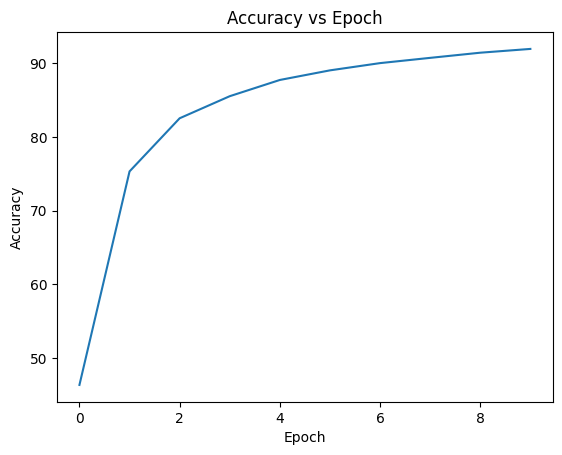

<Figure size 500x300 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.plot(np.arange(epoch+1), acc_LIST_CNN)
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.figure(figsize = (5,3))

# END TODO 

### 2.3.4 CNN Model Test Accuracy (2 points)

---
**TODO:**
Calculate the Test Accuracy for the CNN Model we trained above. Save it to the variable named `test_acc_CNN`. The technique for doing this is the same as computing the test accuracy for the logistic regression and FNN classifiers above.

---

In [46]:
# TODO
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        # TODO
        # Get the output
        outputs = cnn(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = torch.tensor(100*correct/ total)
# TODO END

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 92.72000122070312


In [47]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'cnn_test_acc', answer = (test_acc_CNN.item()))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.4. Reflection (2 point - Manually Graded) 



Let's compare the model performance:

From the test accuracies, we can see that FNN works better than Logistic Regression, and CNN works even better than FNN. 

In [48]:
# Simply run this cell, please do not modify
print(f'Test Accuracy for Logistic Regression: ' + str(test_acc_log.item()))
print(f'Test Accuracy for FNN: ' + str(test_acc_FNN.item()))
print(f'Test Accuracy for CNN: ' + str(test_acc_CNN.item()))

Test Accuracy for Logistic Regression: 64.55999755859375
Test Accuracy for FNN: 87.19999694824219
Test Accuracy for CNN: 92.72000122070312


---
**TODO:**

Now that you've build an image classification model on a relatively simple dataset, could you think of a real-world practical/complex application/use-case where digit recognition is useful?

---

In [49]:
# (Manual Grading - 2 point)

# Type your response in the following cell as a comment
#
# Digit recognition could be used in computer vision. For instance, since computer vision is used to process information of the world, digit recognition can be another method to do so. 
# With the recognition of the digits in diffeernt text documents or if an image can be seperated into such digits.

## 2.5 Confusion Matrix (Total: 8 points)

We want to give you some insight into how you can further analyze the performance of the classification model you have trained. 

Upto now we have only used accuracy as a measure of performance. Although accuracy is simple and widely used measure, there are drawbacks to using accuracy.

Assume that we are trying to train a model to detect a rare disease from CT images of patients. For simplicity, assume that this rare disease has an incidence rate of 1%.

In this situation, if we train a degenerative model which always predicts that the patient does not have the disease, the accuracy is very high, namely 99%! Obviously in this case, accuracy is not a good measure of performance of the model.

This example serves to motivate confusion matrices and related metrics.

A confusion matrix is defined to be $C \times C$ 2D matrix, where $C$ is number of distinct labels in the dataset. In this matrix, the rows represent the actual labels and the columns represent the predicted labels. 

The $(i, j)$-th entry of the confusion matrix contains the no. of data points where the actual label is $i$ but the model predicted $j$. 

<div>
<img src='https://s2.loli.net/2023/04/02/7T1e5dtYGihvrRN.png', width='600'>
</div>

The provided image is an example of a confusion matrix for binary classification (C = 2), but you can easily imagine this scaling up to C > 2.

From this confusion matrix we can get all sorts of useful metrics such as False Positive Rate (FPR), False Negative Rate (FNR), Recall, Precision, etc... If you are interested in learning more about confusion matrix and related metrics [this wikipedia page](https://en.wikipedia.org/wiki/Confusion_matrix#cite_note-11) is a good place to look at. 







### 2.5.1 Create a confusion matrix (4 points)

---

**TODO:**
1. For the test dataset using the CNN model you have trained above, create a confusion matrix. 
2. Save the confusion matrix as a pandas dataframe called `confusion_matrix_df`.

---
**Hint:** Look at what you've done in 2.3.4, and see if what you have done can be re-used.

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# TODO

def cm_generator(test_loader):
  
  predictedList = []
  labelsList = []
  with torch.no_grad(): 
    for images, labels in test_loader: 
      labels = labels.type(torch.LongTensor)
      images, labels = images.to(device), labels.to(device)
    # The goal is to obtain two lists of prediction and actual labels.
    # Then, using these two lists, create a confusion matrix dataframe
      outputs = cnn(images)
      _, predicted = torch.max(outputs.data, 1)
      predictedList.extend(predicted.cpu().numpy())
      labelsList.extend(labels.cpu().numpy())
      
    confusion_matrix_df = pd.DataFrame(confusion_matrix(labelsList,predictedList))
    return confusion_matrix_df
  
# END TODO
confusion_matrix_df = cm_generator(test_loader)

In [65]:
#Grader Cell (4 points)
import numpy as np
grader.grade('check_confusion_matrix', (str(type(confusion_matrix_df)), 
                                        confusion_matrix_df.shape, 
                                        confusion_matrix_df.to_numpy().sum(),
                                        np.trace(confusion_matrix_df.to_numpy())
                                        ))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.5.2 Visualizing Confusion Matrix (4 points - Manual Grading)

---
**TODOs:**

Implement the code to visualize the confusion matrix you have created above. This section will be manually graded

Suggested library is using Seaborn heatmap. 

Chart Specifications:
1. Each cell is labled/annotated with associated values. Take a look at the parameter "annot". 
2. Make sure all annotated values are in integers, and not shown in scientific notations. Use the parameter `fmt = "g"`.
3. Add chart title, and axis name label ("Actual" and "Predicted". Check out which axis is associated with either label.
4. Set map color to Green/Blue.
5. To avoid "File Too Large" for submission, please set figure size to (8,4).
---
Resource: [Seaborn Heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html )

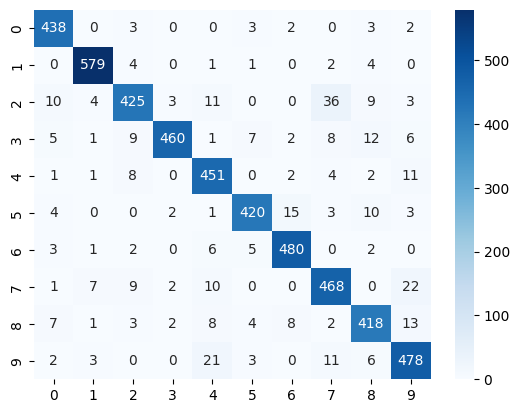

<Figure size 800x400 with 0 Axes>

In [53]:

# TODO
sns.heatmap(confusion_matrix_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.figure(figsize = (8,4))

plt.show()

# END TODO


# Homework Submission

Good job! You have finished the homework :) The submission instructions are as follows:

* **Double check** that you have the correct PennID (all numbers) in the autograder. 

* **Triple check** that you have all plots shown in this Colab notebook before submitting (otherwise, your submission will be subjected to a **penalty of -5 points**).

*  Go to the "File" tab at the top left of the Colab UI, click "Download .ipynb" and then "Download .py".  **Rename** these two files to `homework5.ipynb` and `homework5.py` respectively and upload them to Gradescope.
  - <ins>**WAIT UNTIL THE GRADESCOPE AUTOGRADER FINISHES RUNNING!**</ins> If we have to manually upload this for you after the deadline, **we will apply a penalty of -5 points** (this stacks with any other penatlies)

* You must submit your notebook to receive credit. Post any issues with submission on Ed and make sure to keep in mind the late day policy.

* After you submit your code, the teaching staff will manually grade your Colab notebook in order to validate the correctness of your code.